In [1]:
import glob
import json
import random

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.dataprocessing import get_measured_potential
from tensorflow import distribute as dist
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

2024-03-13 09:14:26.961367: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 09:14:26.961472: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 09:14:26.962305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 09:14:27.049222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class DataGenerator(Sequence):
    def __init__(
        self,
        list_IDs,
        path,
        batch_size=32,
        eit_dim=4096,
        supervised="diameter",
        shuffle=True,
    ):
        "Initialization"
        self.path = path
        self.eit_dim = eit_dim
        self.supervised = supervised
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
        self.max = self.__len__()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        "Generates data containing batch_size samples"  # X : (n_samples, *eit_dim)
        # Initialization
        X = np.empty((self.batch_size, 64, 64, 1))  # EIT signal, self.eit_dim
        y = np.empty((self.batch_size, 1))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # load sample
            tmp = np.load(
                "{0:s}/sample_{1:06d}.npz".format(self.path, ID), allow_pickle=True
            )
            anomaly = tmp["anomaly"].tolist()
            raw_eit = get_measured_potential(tmp, shape_type="matrix")
            # raw_eit = get_measured_potential(tmp, shape_type="vector")
            mean_eit = np.load(
                f"{self.path.split('/')[0]}/datameans/mean_gnd_d_{anomaly.d}_{anomaly.material}.npy",
                allow_pickle=True,
            )
            pot = np.abs(raw_eit - np.reshape(mean_eit,(64,64)))
            # pot = np.abs(raw_eit - mean_eit) # vector eit data shape
            X[
                i,
            ] = np.expand_dims(pot, axis=2)
            #X[
            #    i,
            #] = np.expand_dims(pot, axis=1)
            if self.supervised == "diameter":
                y[
                    i,
                ] = anomaly.d
            elif self.supervised == "material":
                mat_dict = {"acryl": 0, "messing": 1}
                y[
                    i,
                ] = mat_dict[anomaly.material]

            # add normalization?
        return X, y

In [3]:
params = {
    "path": "measurements/datapool/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter" or "material"
    "batch_size": 5,
    "shuffle": True,
}

idx = np.arange(0, 124_200)[:10_000]
np.random.shuffle(idx)

training_generator = DataGenerator(idx, **params)

In [4]:
X, Y = training_generator[0]

In [5]:
print(X.shape, Y.shape)

(5, 64, 64, 1) (5, 1)


In [19]:
Xscaler = tf.keras.layers.Normalization(axis=2)

def model(input_shape=(64, 64, 1), latent_dim=3, kernel=9):
    mapper_input = tf.keras.layers.Input(shape=input_shape)

    # normalize input data
    x = Xscaler(mapper_input)

    # convolutional layers
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Activation("elu")(x)
    #x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    #x = BatchNormalization()(x)
    #x = Activation("elu")(x)
    #x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    #x = BatchNormalization()(x)
    #x = Activation("elu")(x)
    #x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    #x = MaxPooling2D(pool_size=(2, 4))(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = Activation("elu")(x)
    #x = Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return Model(mapper_input, mapper_output)

In [20]:
opt = Adam(learning_rate=1e-3)
model = model(latent_dim=1, kernel=5)
model.compile(optimizer=opt, loss="mse")

model.summary()

#es = EarlyStopping(
#    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
#)
#Xscaler.adapt(X)

history = model.fit(training_generator, batch_size=128, epochs=10)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 normalization_1 (Normaliza  (None, 64, 64, 1)         129       
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 16, 8)         208       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 4, 8)          1608      
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 1, 16)          3216      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 1, 16)          6416      
                                                           

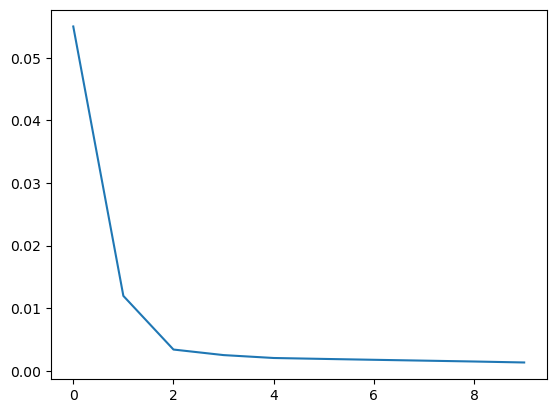

In [16]:
plt.plot(history.history["loss"])

In [18]:
xx,yy = training_generator[0]
model.predict(xx)

1/1 [==============================] - 0s 175ms/step


array([[0.01974127, 0.01856209, 0.01671283],
       [1.0302228 , 1.031304  , 1.02743   ],
       [0.01510264, 0.02062805, 0.01538472],
       [1.0563717 , 1.0588499 , 1.055288  ],
       [0.03291295, 0.03343184, 0.02950861]], dtype=float32)